# Wildfire Susceptibility mapping

**Abstract**

Table of Contents : 

- [Preprocessing]()

## Libraries

In [3]:
import numpy as np 
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_rows', 4)

## Preprocessing

In [4]:
LAND_COVER_PATH = 'data/land_cover_2000/U2006_CLC2000_V2020_20u1.tif'
DEM_PATH_v1 = 'data/dem/eu_dem_v11_E30N20.TIF'
DEM_PATH_V0 = 'data/dem_v00/EUD_CP-DEMS_3500025000-AA.tif'
DEM_REPROJ_PATH = 'data/dem_v00/dem_reproj.tif'
DEM_REPROJ_RES_PATH = 'data/dem_v00/dem_test.tif'
VEGETATION_PATH = 'data/'
BURNT_AREAS_PATH = 'data/burnt_areas/modis.ba.poly.shp'
PROTECTED_AREAS_PATH = 'data/ens/ens.shp'
CONTOURS_PATH = 'data/contours/departements-20180101.shp'
SLOPE_PATH = 'data/slope/EUD_CP-SLOP_3500025000-AA.tif'
SLOPE_REPROJ_PATH = 'data/slope/sl_test.tif'

In [5]:
import geopandas as gpd
import shapely.geometry
import shapely.wkt

import rasterio 
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.features import rasterize

import subprocess

# CRS transformations
import pyproj

# raster operations
import os
from osgeo import gdal

import rasterio.mask 
import rasterstats
import math

### Contouring

In [6]:
contours = gpd.read_file(CONTOURS_PATH)

In [7]:
contours.shape

(102, 6)

In [8]:
contours.head()

,code_insee,nom,nuts3,wikipedia,surf_km2,geometry
0,974,La RÃ©union,FR940,fr:La RÃ©union,2505.0,"MULTIPOLYGON (((55.21643 -21.03904, 55.21652 -..."
1,11,Aude,FR811,fr:Aude (dÃ©partement),6343.0,"POLYGON ((1.68872 43.27368, 1.69001 43.27423, ..."
...,...,...,...,...,...,...
3,13,Bouches-du-RhÃ´ne,FR823,fr:Bouches-du-RhÃ´ne,5247.0,"MULTIPOLYGON (((4.23014 43.46047, 4.23025 43.4..."
4,47,Lot-et-Garonne,FR614,fr:Lot-et-Garonne,5385.0,"POLYGON ((-0.14058 44.22648, -0.12931 44.23218..."


<AxesSubplot: >

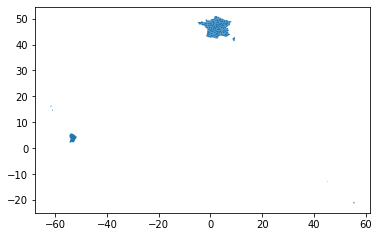

In [9]:
contours.plot()

We will use the department number to select the regions of interest : in this case, Pyrénées-Atlantiques (64) and Hautes-Pyrénées (65).

<AxesSubplot: >

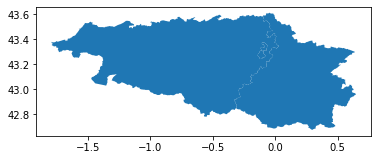

In [10]:
pyrenees = contours[(contours.code_insee == '64') | (contours.code_insee == '65')]
pyrenees.plot()

An important information to note is that the CRS used is the WGS 84: as we are in 2D, the CRS is commonly named EPSG 4326.

### Slope
With the help of QGIS application, we performed the necessary transformation to simplify the CRS of the slope and DEM rasters.

In [10]:
slope_reproj = rasterio.open(SLOPE_REPROJ_PATH)
slope = rasterio.open(SLOPE_PATH)

In [11]:
slope.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 40000,
 'height': 40000,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["JRC-EGCS",GEOGCS["ETRS89",DATUM["unnamed",SPHEROID["GRS 1980",6378137,298.257222100004]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(25.0, 0.0, 3000000.0,
        0.0, -25.0, 3000000.0)}

In [12]:
slope_reproj.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10000,
 'height': 10000,
 'count': 1,
 'crs': CRS.from_wkt('LOCAL_CS["ETRS89-extended / LAEA Europe",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(100.0, 0.0, 3000000.0,
        0.0, -100.0, 3000000.0)}

### Digital Elevation Model

In [17]:
%%time

# open a connection to the raster
dem = rasterio.open(DEM_PATH_V0)
dem_reproj = rasterio.open(DEM_REPROJ_PATH)
dem_test = rasterio.open(DEM_REPROJ_RES_PATH)

Wall time: 29.9 ms


In [263]:
# plot the raster
show(dem)

MemoryError: Unable to allocate 5.96 GiB for an array with shape (1, 40000, 40000) and data type float32

In [14]:
# raster metadata
dem.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 40000,
 'height': 40000,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["JRC-EGCS",GEOGCS["ETRS89",DATUM["unnamed",SPHEROID["GRS 1980",6378137,298.257222100004]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(25.0, 0.0, 3000000.0,
        0.0, -25.0, 3000000.0)}

In [15]:
dem_reproj.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 40000,
 'height': 40000,
 'count': 1,
 'crs': CRS.from_wkt('LOCAL_CS["ETRS89-extended / LAEA Europe",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(25.0, 0.0, 3000000.0,
        0.0, -25.0, 3000000.0)}

In [18]:
dem_test.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 10000,
 'height': 10000,
 'count': 1,
 'crs': CRS.from_wkt('LOCAL_CS["ETRS89-extended / LAEA Europe",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(100.0, 0.0, 3000000.0,
        0.0, -100.0, 3000000.0)}

In [285]:
land_cov.meta

{'driver': 'GTiff',
 'dtype': 'int8',
 'nodata': -128.0,
 'width': 65000,
 'height': 46000,
 'count': 1,
 'crs': CRS.from_wkt('LOCAL_CS["ETRS_1989_LAEA",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(100.0, 0.0, 900000.0,
        0.0, -100.0, 5500000.0)}

The metadata of the raster file give us important informations : the CRS used is the ETRS_1989 or EPSG 3035 if we use the EPSG classification. The unit used is the meter, its resolution is 25x25 meters with the origin starting at (3000000.0, 3000000.0) in its corresponding CRS.  
The land cover raster had a resolution of 100x100 meters, therefore we need to aggregate the values of four non-overlapping  adjacent cells to obtain the same resolution. With the help of QGIS application, we have reprojected DEM and slope data so that it is recognized by the ESPG registry. It will help us merge the transform of the different rasters.  

In [19]:
%%time
# we have used Qgis and gdal to perform the projections and change of resolutions 
'''
# change the resolution, transform and crs of dem data to match land cover metadata
# use rasterio.reproject() using the same crs as src and dst

with rasterio.open(DEM_PATH) as src_dem:
    print(type(src_dem))
    
    # transform for input raster
    src_transform = src_dem.transform
    # dem crs not recognized by rasterio : we assume that land cover and dem data have the same crs : epsg 3035
    dst_crs = land_cov.crs
    src_crs = land_cov.crs
    
    # calculate the transform matrix for the output
    dst_transform, width, height = calculate_default_transform(
        dst_crs,    # source CRS
        dst_crs,    # destination CRS
        src_dem.width,    # column count
        src_dem.height,  # row count
        *src_dem.bounds,  # unpacks outer boundaries (left, bottom, right, top)
    )
    
    # set properties for output
    dst_kwargs = src_dem.meta.copy()
    dst_kwargs.update(
        {
            "crs": dst_crs,
            "transform": dst_transform,
            "width": width,
            "height": height,
            "nodata": land_cov.meta['nodata'], 
        }
    )
    
    print(src_dem.meta)
    
    with rasterio.open("dem_reproj", "w", **dst_kwargs) as dst:
        reproject(
            source = src_dem,
            destination = dst,
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest)'''

Wall time: 0 ns


'\n# change the resolution, transform and crs of dem data to match land cover metadata\n# use rasterio.reproject() using the same crs as src and dst\n\nwith rasterio.open(DEM_PATH) as src_dem:\n    print(type(src_dem))\n    \n    # transform for input raster\n    src_transform = src_dem.transform\n    # dem crs not recognized by rasterio : we assume that land cover and dem data have the same crs : epsg 3035\n    dst_crs = land_cov.crs\n    src_crs = land_cov.crs\n    \n    # calculate the transform matrix for the output\n    dst_transform, width, height = calculate_default_transform(\n        dst_crs,    # source CRS\n        dst_crs,    # destination CRS\n        src_dem.width,    # column count\n        src_dem.height,  # row count\n        *src_dem.bounds,  # unpacks outer boundaries (left, bottom, right, top)\n    )\n    \n    # set properties for output\n    dst_kwargs = src_dem.meta.copy()\n    dst_kwargs.update(\n        {\n            "crs": dst_crs,\n            "transform": d

### Land Cover

In [21]:
# 2000 land_cover data
land_cov_2000 = rasterio.open(LAND_COVER_PATH)

In [ ]:
# visualize with QGIS: memory problem
show(land_cov_2000)

In [23]:
land_cov_2000.meta

{'driver': 'GTiff',
 'dtype': 'int8',
 'nodata': -128.0,
 'width': 65000,
 'height': 46000,
 'count': 1,
 'crs': CRS.from_wkt('LOCAL_CS["ETRS_1989_LAEA",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(100.0, 0.0, 900000.0,
        0.0, -100.0, 5500000.0)}

The metadata of the raster file give us important informations : the CRS used is the ETRS_1989 or EPSG 3035 if we use the EPSG classification. The unit used is the meter, its resolution is 100x100 meters with the origin starting at (900000.0, 900000.0) in its corresponding CRS.

In [ ]:
# the memory footprint of the raster seems heavy, thus we will need to mask the data using the contours shapefile we have seen previously
layer_cov = land_cov_2000.read(1)

In [26]:
land_cov_2000.meta

{'driver': 'GTiff',
 'dtype': 'int8',
 'nodata': -128.0,
 'width': 65000,
 'height': 46000,
 'count': 1,
 'crs': CRS.from_wkt('LOCAL_CS["ETRS_1989_LAEA",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(100.0, 0.0, 900000.0,
        0.0, -100.0, 5500000.0)}

In [24]:
dem_test.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 10000,
 'height': 10000,
 'count': 1,
 'crs': CRS.from_wkt('LOCAL_CS["ETRS89-extended / LAEA Europe",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(100.0, 0.0, 3000000.0,
        0.0, -100.0, 3000000.0)}

Now we need to crop the raster file to the area of interest in the study that is the pyrenees dataframe we have previously defined.  
First we need to convert the CRS of the contours vector into the CRS of land cover/dem rasters.  
For simplicity, we consider that the land cover/dem have the same crs EPSG:3035 (ETRS89-LAEA)

In [29]:
# affine transform of vector shapes ?

pyrenees_proj = pyrenees.to_crs(epsg='3035')

land_cover_mask, land_cover_transform_mask = rasterio.mask.mask(
    land_cov_2000, 
    pyrenees_proj.geometry, 
    crop=True, 
    nodata=land_cov_2000.meta['nodata']
)

dem_mask, dem_transform_mask = rasterio.mask.mask(
    dem_test, 
    pyrenees_proj.geometry,
    crop=True, 
    nodata=dem_test.meta['nodata']
)

slope_mask, slope_transform_mask = rasterio.mask.mask(
    dem_test, 
    pyrenees_proj.geometry,
    crop=True, 
    nodata=dem_test.meta['nodata']
)

# TODO: homegeneise land cover and dem data beforehand 
print('LAND COVER CROPPING')
print(land_cover_mask.squeeze().shape)
print(land_cover_transform_mask)

print('\nDEM CROPPING')
print(dem_mask.squeeze().shape)
print(dem_transform_mask)

LAND COVER CROPPING
(1157, 1944)
| 100.00, 0.00, 3367000.00|
| 0.00,-100.00, 2341200.00|
| 0.00, 0.00, 1.00|

DEM CROPPING
(1157, 1944)
| 100.00, 0.00, 3367000.00|
| 0.00,-100.00, 2341200.00|
| 0.00, 0.00, 1.00|


### Burnt Areas

TODO: EDA on this file

We will use this file to label the areas of interest in this study. First we will perform an exploratory data analysis to give us insights on the nature of the data.

In [30]:
burnt = gpd.read_file(BURNT_AREAS_PATH)

In [31]:
burnt.shape

(62822, 19)

In [32]:
burnt[burnt.COUNTRY=='FR'].count()

# EDA : 
# plot total number of fires per country 
# plot total number of fires per year  

id          3158
FIREDATE    3158
            ... 
CLASS       3158
geometry    3158
Length: 19, dtype: int64

<AxesSubplot: >

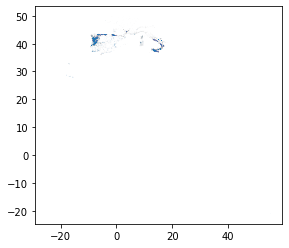

In [33]:
burnt[(burnt.COUNTRY == 'IT') | (burnt.COUNTRY == 'PT') |
     (burnt.COUNTRY == 'ES') | (burnt.COUNTRY == 'FR')].plot()

In [198]:
burnt['geometry'].type.value_counts()

Polygon         61707
MultiPolygon     1115
dtype: int64

In [199]:
burnt['geometry'].crs

{'init': 'epsg:4326'}

We see that the shapefile is in different Coordinate Reference System than land cover and digital elevation model data (coming from Copernicus sources). The next step is to project this shapefile from CRS EPSG 4236 to EPSG 3035.

In [219]:
# We restrict the shapefile to fires happening in France 
burnt_pyrenees = burnt[(burnt.COUNTRY=='FR') & (burnt.PROVINCE=='Hautes-Pyrénées') | (burnt.PROVINCE == 'Pyrénées-Atlantiques')]

# change crs to espg 3035
burnt_pyrenees = burnt_pyrenees.to_crs(epsg='3035')

# we extract the year of the firedate and change the type to int
burnt_pyrenees['YEAR'] = burnt_pyrenees['FIREDATE'].apply(lambda d: int(d[:4]))
burnt_pyrenees.head()

,id,FIREDATE,LASTUPDATE,COUNTRY,PROVINCE,COMMUNE,AREA_HA,BROADLEA,CONIFER,MIXED,SCLEROPH,TRANSIT,OTHERNATLC,AGRIAREAS,ARTIFSURF,OTHERLC,PERCNA2K,CLASS,geometry,YEAR
3523,178793,2001-12-25 00:00:00,2001-12-25 00:00:00,FR,Pyrénées-Atlantiques,Sainte-Engrâce,17,99.999999999375,0,0,0,0,0,0,0,0,2.1781429291483865,FireSeason,"POLYGON ((3438525.283 2272578.577, 3438880.513...",2001
3612,178973,2001-12-25 00:00:00,2001-12-27 00:00:00,FR,Pyrénées-Atlantiques,Lanne-en-Barétous,70,1.4285714285693878,69.9999999999,25.71428571424898,0,0,2.8571428571387756,0,0,0,4.115763973318598,FireSeason,"POLYGON ((3441180.296 2276133.480, 3440470.228...",2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3822,30231,2002-01-01 00:00:00,2002-01-01 00:00:00,FR,Pyrénées-Atlantiques,Tardets-Sorholus,525,19.011406844102847,4.372623574143655,0,0,0,65.01901140683174,11.596958174902737,0,0,0.7337047692039197,FireSeason,"POLYGON ((3441207.794 2288728.780, 3441189.152...",2002
3994,30543,2002-01-01 00:00:00,2002-01-01 00:00:00,FR,Pyrénées-Atlantiques,Ascain,176,20.454545454533836,0,0,0,0,74.9999999999574,3.409090909088972,1.1363636363629908,0,5.2270921294597805,FireSeason,"POLYGON ((3378629.527 2321046.476, 3378609.433...",2002


In [37]:
# rasterize the burnt areas to combine it with other rasters
# partition the fire date depending on the dates on the available land cover data

for g in burnt['geometry'].tolist():
    print((1, g))

(1, <shapely.geometry.polygon.Polygon object at 0x000001FD93E7E130>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FD93E7EF40>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FD93F18EE0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FD93DDA940>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FD93FAC190>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FD93FAC310>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FD93FAC2B0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FD93FACB20>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FD93FAC280>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FD93FACAF0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FD93E8B400>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FD93D6AC40>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FD93D6AE80>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FD93F827C0>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FD93DCCE50>)
(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FD93DCCEE0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FD93DCCF70>)
(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FD93DCCFD0>)
(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FD94251B50>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FD94251BB0>)
(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FD94251BE0>)
(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FD94251C40>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FD94251CA0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FD94251CD0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FD94251D00>)
(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FD94251D30>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FD94251D90>)
(1, <shapely.geometry.multipolygo

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB33796D0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB3379700>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB3379730>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB3379760>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB3379790>)
(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FDB33797C0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB3379820>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB3379850>)
(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FDB3379880>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB33798E0>)
(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FDB3379910>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB3379970>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB33799A0>)
(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FDB3379

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB374C280>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB374C2B0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB374C2E0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB374C310>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB374C340>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB374C370>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB374C3A0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB374C3D0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB374C400>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB374C430>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB374C460>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB374C490>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB374C4C0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB374C4F0>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB38F7D60>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB38F7D90>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB38F7DC0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB38F7DF0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB38F7E20>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB38F7E50>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB38F7E80>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB38F7EB0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB38F7EE0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB38F7F10>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB38F7F40>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB38F7F70>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB38F7FA0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB38F7FD0>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB3A15640>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB3A15670>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB3A156A0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB3A156D0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB3A15700>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB3A15730>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB3A15760>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB3A15790>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB3A157C0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB3A157F0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB3A15820>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB3A15850>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB3A15880>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB3A158B0>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FDB4DC6DC0>)
(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FDB4DC6E20>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB4DC6E80>)
(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FDB4DC6EB0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB4DC6F10>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB4DC6F40>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB4DC6F70>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB4DC6FA0>)
(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FDB4DC6FD0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB4DEB070>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB4DEB0A0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB4DEB0D0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB4DEB100>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB4DEB

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB4F41670>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB4F416A0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB4F416D0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB4F41700>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB4F41730>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB4F41760>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB4F41790>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB4F417C0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB4F417F0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB4F41820>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB4F41850>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB4F41880>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB4F418B0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB4F418E0>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB50A45E0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB50A4610>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB50A4640>)
(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FDB50A4670>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB50A4700>)
(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FDB50A4730>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB50A4790>)
(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FDB50A47C0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB50A4820>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB50A4850>)
(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FDB50A4880>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB50A48E0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB50A4910>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB50A4

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5108FA0>)
(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FDB5108FD0>)
(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FDB5111070>)
(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FDB51110D0>)
(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FDB5111130>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5111190>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB51111C0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB51111F0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5111220>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5111250>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5111280>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB51112B0>)
(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FDB51112E0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB51EE760>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB51EE790>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB51EE7C0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB51EE7F0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB51EE820>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB51EE850>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB51EE880>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB51EE8B0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB51EE8E0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB51EE910>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB51EE940>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB51EE970>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB51EE9A0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB51EE9D0>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5244880>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB52448B0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB52448E0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5244910>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5244940>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5244970>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB52449A0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB52449D0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5244A00>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5244A30>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5244A60>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5244A90>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5244AC0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5244AF0>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5BB2BE0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5BB2C10>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5BB2C40>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5BB2C70>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5BB2CA0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5BB2CD0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5BB2D00>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5BB2D30>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5BB2D60>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5BB2D90>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5BB2DC0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5BB2DF0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5BB2E20>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5BB2E50>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5D02460>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5D02490>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5D024C0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5D024F0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5D02520>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5D02550>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5D02580>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5D025B0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5D025E0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5D02610>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5D02640>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5D02670>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5D026A0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5D026D0>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5E51460>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5E51490>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5E514C0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5E514F0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5E51520>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5E51550>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5E51580>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5E515B0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5E515E0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5E51610>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5E51640>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5E51670>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5E516A0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5E516D0>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5FCF280>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5FCF2B0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5FCF2E0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5FCF310>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5FCF340>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5FCF370>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5FCF3A0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5FCF3D0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5FCF400>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5FCF430>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5FCF460>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5FCF490>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5FCF4C0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB5FCF4F0>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB608DC70>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB608DCA0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB608DCD0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB608DD00>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB608DD30>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB608DD60>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB608DD90>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB608DDC0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB608DDF0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB608DE20>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB608DE50>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB608DE80>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB608DEB0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB608DEE0>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB61D99D0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB61D9A00>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB61D9A30>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB61D9A60>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB61D9A90>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB61D9AC0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB61D9AF0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB61D9B20>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB61D9B50>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB61D9B80>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB61D9BB0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB61D9BE0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB61D9C10>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB61D9C40>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FDB628C250>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB628C2B0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB628C2E0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB628C310>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB628C340>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB628C370>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB628C3A0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB628C3D0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB628C400>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB628C430>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB628C460>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB628C490>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB628C4C0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB628C4F0>)
(1, <shapely.geometry.po

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB630E9A0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB630E9D0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB630EA00>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB630EA30>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB630EA60>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB630EA90>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB630EAC0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB630EAF0>)
(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FDB630EB20>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB630EB80>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB630EBB0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB630EBE0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB630EC10>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB630EC40>)
(1, <shapely.geometry.po

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB63F82B0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB63F82E0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB63F8310>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB63F8340>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB63F8370>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB63F83A0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB63F83D0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB63F8400>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB63F8430>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB63F8460>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB63F8490>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB63F84C0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB63F84F0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB63F8520>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB64558E0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6455910>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6455940>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6455970>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB64559A0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB64559D0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6455A00>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6455A30>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6455A60>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6455A90>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6455AC0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6455AF0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6455B20>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6455B50>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6574100>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6574130>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6574160>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6574190>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB65741C0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB65741F0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6574220>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6574250>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6574280>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB65742B0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB65742E0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6574310>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6574340>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6574370>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6726CD0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6726D00>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6726D30>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6726D60>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6726D90>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6726DC0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6726DF0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6726E20>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6726E50>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6726E80>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6726EB0>)
(1, <shapely.geometry.multipolygon.MultiPolygon object at 0x000001FDB6726EE0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6726F40>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6726F70>)
(1, <shapely.geometry.po

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6936BE0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6936C10>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6936C40>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6936C70>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6936CA0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6936CD0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6936D00>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6936D30>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6936D60>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6936D90>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6936DC0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6936DF0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6936E20>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6936E50>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6A9EB50>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6A9EB80>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6A9EBB0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6A9EBE0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6A9EC10>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6A9EC40>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6A9EC70>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6A9ECA0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6A9ECD0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6A9ED00>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6A9ED30>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6A9ED60>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6A9ED90>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB6A9EDC0>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7C59340>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7C59370>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7C593A0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7C593D0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7C59400>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7C59430>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7C59460>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7C59490>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7C594C0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7C594F0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7C59520>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7C59550>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7C59580>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7C595B0>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7DDC8E0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7DDC910>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7DDC940>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7DDC970>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7DDC9A0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7DDC9D0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7DDCA00>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7DDCA30>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7DDCA60>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7DDCA90>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7DDCAC0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7DDCAF0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7DDCB20>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7DDCB50>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7F93040>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7F93070>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7F930A0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7F930D0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7F93100>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7F93130>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7F93160>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7F93190>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7F931C0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7F931F0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7F93220>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7F93250>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7F93280>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB7F932B0>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB8114580>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB81145B0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB81145E0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB8114610>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB8114640>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB8114670>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB81146A0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB81146D0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB8114700>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB8114730>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB8114760>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB8114790>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB81147C0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB81147F0>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB81D5610>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB81D5640>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB81D5670>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB81D56A0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB81D56D0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB81D5700>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB81D5730>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB81D5760>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB81D5790>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB81D57C0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB81D57F0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB81D5820>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB81D5850>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB81D5880>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB832ADC0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB832ADF0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB832AE20>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB832AE50>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB832AE80>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB832AEB0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB832AEE0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB832AF10>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB832AF40>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB832AF70>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB832AFA0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB832AFD0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB835A040>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB835A070>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB841CEB0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB841CEE0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB841CF10>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB841CF40>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB841CF70>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB841CFA0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB841CFD0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB843E040>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB843E070>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB843E0A0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB843E0D0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB843E100>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB843E130>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB843E160>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB84DCD30>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB84DCD60>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB84DCD90>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB84DCDC0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB84DCDF0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB84DCE20>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB84DCE50>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB84DCE80>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB84DCEB0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB84DCEE0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB84DCF10>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB84DCF40>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB84DCF70>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB84DCFA0>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB862FB20>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB862FB50>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB862FB80>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB862FBB0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB862FBE0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB862FC10>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB862FC40>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB862FC70>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB862FCA0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB862FCD0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB862FD00>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB862FD30>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB862FD60>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB862FD90>)
(1, <shapely.geometry.polygon.Poly

(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB8818130>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB8818160>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB8818190>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB88181C0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB88181F0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB8818220>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB8818250>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB8818280>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB88182B0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB88182E0>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB8818310>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB8818340>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB8818370>)
(1, <shapely.geometry.polygon.Polygon object at 0x000001FDB88183A0>)
(1, <shapely.geometry.polygon.Poly

KeyboardInterrupt: 

### Protected Areas (France)

TODO: EDA with label of burnt areas

In [57]:
protected = gpd.read_file(PROTECTED_AREAS_PATH)

In [58]:
protected.head()

,OBJECTID,ID_LOCAL,ID_MNHN,NOM_SITE,DATE_CREA,MODIF_ADM,MODIF_GEO,URL_FICHE,SURF_OFF,ACTE_DEB,...,P10_PUBLIC,P11_DD,P12_AUTRE,ID_TECH,SURF_SIG,CODE_TERRI,STATUT_FON,SHAPE_AREA,SHAPE_LEN,geometry
0,1,None,FR4700001,None,None,None,None,None,0.0,None,...,None,None,None,29_01,0.564999,000,None,0.0,0.0,"MULTIPOLYGON (((199437.759 6763968.161, 199433..."
1,2,None,FR4700002,None,None,None,None,None,0.0,None,...,None,None,None,29_02,55.937425,000,None,0.0,0.0,"MULTIPOLYGON (((135017.696 6857815.407, 135019..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,4,None,FR4700004,None,None,None,None,None,0.0,None,...,None,None,None,29_04,39.168999,000,None,0.0,0.0,"MULTIPOLYGON (((145131.796 6863931.431, 145133..."
4,5,None,FR4700005,None,None,None,None,None,0.0,None,...,None,None,None,29_05,0.406897,000,None,0.0,0.0,"POLYGON ((185215.026 6772626.016, 185215.365 6..."


<AxesSubplot: >

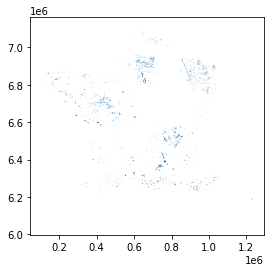

In [59]:
protected.plot()

In [169]:
protected['geometry'].crs

{'proj': 'lcc',
 'lat_1': 44,
 'lat_2': 49,
 'lat_0': 46.5,
 'lon_0': 3,
 'x_0': 700000,
 'y_0': 6600000,
 'ellps': 'GRS80',
 'units': 'm',
 'no_defs': True}

In [286]:
dem_reproj.crs

CRS.from_wkt('LOCAL_CS["ETRS89-extended / LAEA Europe",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

<AxesSubplot: >

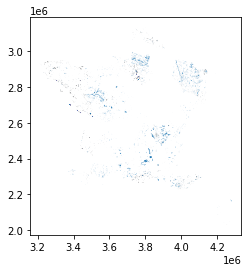

In [288]:
protected.to_crs(epsg='3035').plot()

### Vegetation